# Classification Predictions on Iris dataset

In this notebook we are going to use a well known dataset [Fisher's Iris](https://en.wikipedia.org/wiki/Iris_flower_data_set) to illustrate how `classification` problems work with `Prescience`.

## Initial Data Analysis

We previously downloaded locally the file containing data as csv. Let's have a look at what is inside the first 10 rows.

In [1]:
# Local directory in which we saved the data
INPUT = 'data/iris.csv'
# Our local data is a CSV and has a header row
HAS_HEADER = True

import pandas
from IPython.core.display import HTML
INITIAL_DATAFRAME = pandas.read_csv(INPUT)
HTML(INITIAL_DATAFRAME.head(10).to_html())

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


We can see that the initial data is composed of 5 columns :
* `sepal_length` : The length of the sepal
* `sepal_width` : The width of the sepal
* `petal_length` : The length of the petal
* `petal_width` : The width of the sepal
* `label` : The category (class) of the iris

The first 4 properties are measured characteristics of iris flowers.

The last property is the category that we want to predict. An Iris can identify as one between 3 categories `Iris-setosa`, `Iris-versicolor`, `Iris-virginica`

## Upload on Prescience and parse the data

Now that we had a first look locally on our data, let's upload it on prescience.

When we upload data on prescience, it automatically starts a `parse task`. A `parse task` is responsible for doing some pre-analysis on your data by creating a `source` object. You can choose the name that you want to give to your source, it is known as the `source_id`.

In [2]:
# Name that you want to give to your source object
SOURCE_ID = 'iris'

In [3]:
from prescience_client import prescience
import matplotlib

# We create a local file input from our csv file
csv_input = prescience.csv_local_file_input(INPUT, headers=HAS_HEADER)
# We start a parse task on prescience and watch for it (i.e we wait until the task ends)
parse_task = csv_input.parse(source_id=SOURCE_ID).watch()
# We get back the created source from the finished task
source = parse_task.source()
# We display the computed sources statistics of the schema
source.schema().show('html')

Uploading source with following arguments :
{
    "source_id": "iris",
    "type": "CSV",
    "headers": true,
    "separator": "COMMA"
}
Task parse 27f7d27a-cfbc-4cb9-b8cc-c385729d526c DONE


,name,type,nullable,n_cat,ratio,n_pop,median,mode,positive
0,sepal_length,double,True,0,None,None,5.8,None,True
1,sepal_width,double,True,0,None,None,3.0,None,True
2,petal_length,double,True,0,None,None,4.3,None,True
3,petal_width,double,True,0,None,None,1.3,None,True
4,label,string,True,3,None,None,0.0,Iris-virginica,True


As you can see in the previous table, the `parse` task correctly find the schema of your data as well as some statistics about it.

Moreover you can now see your source object available when you asks to list all the sources of your project:

In [4]:
# Display the list of all sources in your prescience project
prescience.sources().show('html')

,source_id,status,input_type,info
0,iris,BUILT,CSV,None


You can even plot your source object if you want to visually see your timeserie. For doing so you will just need to indicate the name of the column used as `x`.

Directory '/tmp/.prescience/cache' doesn't exists. Creating it...
Directory '/tmp/.prescience/cache/sources' doesn't exists. Creating it...
Updating cache for source 'iris' : /tmp/.prescience/cache/sources/iris


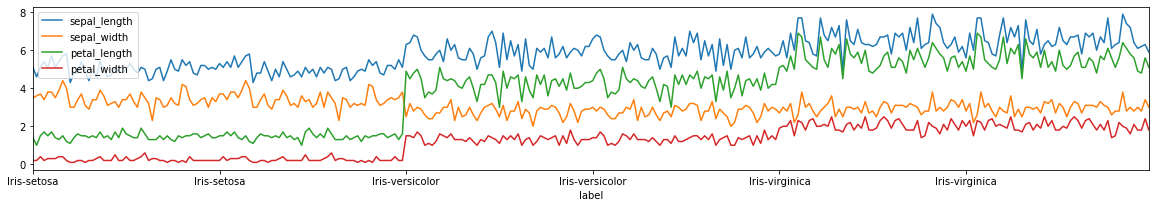

In [5]:
%matplotlib inline
import matplotlib
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 3)
source.plot(x='label')

## Problem Definition

Now we want to be able to make predictions based on this time-series and we want to let prescience infer the predictive model for us. For that purpose, we are going to start an `auto-ml task` after defining problem's metadata.

### The problem type

It is the problem that we want to solve. In this case it's a `time_series_forecast`.

In [6]:
PROBLEM_TYPE = 'classification'

### The label column
It the the column that you want to predict. In our case, it is the `label` column.

In [7]:
LABEL_COLUMN = 'label'

### The scoring metric
It is the metric that we want to use to evaluate the relevance of trained models. In case of `time_series_forecast` the `mean square error` (short: `mse`) is a good metric.

In [8]:
SCORING_METRIC = 'accuracy'

### The number of fold
It is the number of part in which your time-series will be split to evaluate the relevance of trained model. In our case we dont' have so many rows in out initial data so we are going to choose a small number : `2`

In [9]:
NB_FOLD = 10

## Start the Automated Machine Learning Task
With all the previous information we can start the auto-ml task and wait for it to complete (This can take some times). We will see later that this task creates 2 objects : a `dataset` and a `model` that's why the functions returns a task and 2 identifiers.

In [10]:
# Start an AUTO-ML task
task, dataset_id, model_id = source.start_auto_ml(
    label_id=LABEL_COLUMN,
    problem_type=PROBLEM_TYPE,
    scoring_metric=SCORING_METRIC,
    nb_fold=NB_FOLD,
)
task.watch()

Starting AutoML task with following arguments :
{
    "dataset_id": "iris_dataset_KYv0ZjJ",
    "label_id": "label",
    "model_id": "iris_model_KYv0ZjJ",
    "problem_type": "classification",
    "scoring_metric": "accuracy",
    "custom_parameters": {},
    "optimization_method": "SMAC",
    "multiclass": false,
    "nb_fold": 10
}
Task model-metrics bf12fd39-f2fe-47b0-adbc-5ba734c03841 DONE


The finality of an `auto-ml task` is to automatically find and deploy a `model` that makes correct predictions based on you initial data. You can access it by its `model_id`.

In [11]:
# Access the created model on prescience
model = prescience.model(model_id)

## Under the hood

As already told before, an auto-ml tasks start from a source object and creates 2 other objects, first a dataset and then a model. You can see the relationship between each other by doing so : 

In [12]:
source.tree().show()

Source(iris)
 +-- Dataset(iris_dataset_KYv0ZjJ)
     +-- Model(iris_model_KYv0ZjJ)


### The Source object

The source object is almost like your original data, except that it holds some metadata inside that have been computed during the parse tasks. We wont describe all the metadata here but this is several statistics like :
* The standard deviation for each column
* The type of data contained in the column (integer, boolean, text, etc...)
* If the column can contains `null` values
* etc...

You can see the computed statistic on your source by doing so :

In [13]:
source.schema().show('html')

,name,type,nullable,n_cat,ratio,n_pop,median,mode,positive
0,sepal_length,double,True,0,None,None,5.8,None,True
1,sepal_width,double,True,0,None,None,3.0,None,True
2,petal_length,double,True,0,None,None,4.3,None,True
3,petal_width,double,True,0,None,None,1.3,None,True
4,label,string,True,3,None,None,0.0,Iris-virginica,True


### The dataset object

The `dataset` object contains the same data than in your `source` except that this data has been transformed so that it can be understandable by machine learning algorithms.

The rules of transformation won't be described here but all you have to know is that previously computed statistics are used to choose the good transformation strategy.

In [19]:
df = prescience.dataset_dataframe(dataset_id, test_part=False)
HTML(df.head(10).to_html())

Directory '/tmp/.prescience/cache/datasets' doesn't exists. Creating it...
Directory '/tmp/.prescience/cache/datasets/iris_dataset_KYv0ZjJ/train' doesn't exists. Creating it...
Updating cache for source 'iris_dataset_KYv0ZjJ' : /tmp/.prescience/cache/datasets/iris_dataset_KYv0ZjJ/train


,label,scaled_imputed_sepal_width,scaled_imputed_petal_width,scaled_imputed_petal_length,scaled_imputed_sepal_length
0,Iris-setosa,1.059464,-1.308663,-1.336144,-0.891502
1,Iris-setosa,0.132969,-1.308663,-1.279206,-1.495077
2,Iris-setosa,1.985960,-1.044780,-1.165330,-0.529357
3,Iris-setosa,0.827841,-1.308663,-1.279206,-1.012217
4,Iris-setosa,0.596217,-0.912839,-1.165330,-0.891502
5,Iris-setosa,1.059464,-1.308663,-1.393082,-0.408642
6,Iris-setosa,0.827841,-1.308663,-1.279206,-0.891502
7,Iris-setosa,0.596217,-1.308663,-1.336144,-1.012217
8,Iris-versicolor,-0.561902,0.142692,0.428933,-0.167213
9,Iris-versicolor,-2.414893,-0.253132,-0.140447,-1.012217


The `dataset` object is created from a `source` with a `preprocess task`. Another things to note is that the preprocess task is responsible for creating the `folds` that we previously talk about on `Problem Definition` part.

You wan easily see created `folds` :

In [20]:
# TODO

As you can see, each fold is composed of 2 parts :
* A train part which is used to train machine learning algorithms
* A test part which is used to evalute the relevance of a model

It is a standard process in machine learning in order to evaluate relevancy of machine learning algorithms on data that they have never seen before.

### The model object

The `model` object is created from a `dataset` with a `train task` however a train task needs to be launched on a specific machine learning algorithm with defined parameters. That's why there is an intermediate task which is called the `optimization task`.

The aim of an optimization task is to use the previously created folds of our dataset to train a lot of machine learning algorithms with different hyperparameters, evaluate them and find the best.

All results of evaluations are stored in prescience into objects called `evaluations results`. You can request the visualisation of previously computed evaluation by doing so :

In [16]:
evaluation_results = prescience.get_evaluation_results(
    dataset_id,
    # Sort all the results by the selected scoring metric
    sort_column=f'costs.{SCORING_METRIC}'
)
evaluation_results.show('html')

,uuid,status,config_name,past_steps,horizon,discount,accuracy_cost,cohen_kappa_cost,f1_micro_cost,f1_macro_cost,roc_auc_micro_cost,roc_auc_macro_cost,average_precision_micro_cost,average_precision_macro_cost
0,327a8ecd-3d06-4bc6-8b4e-a80827a23343,BUILT,skgradientboostingclassifier,-,-,-,0.004,0.006,0.004,0.004,0.001,0.000,0.001,0.001
1,24e71ef0-068e-4d3f-9cd6-82af3f82fe60,BUILT,xgboostclassifier,-,-,-,0.004,0.006,0.004,0.004,0.001,0.000,0.001,0.001
2,a4efb83d-bceb-48f3-ba78-06a4befa29eb,BUILT,sklogisticregressionclassifier,-,-,-,0.026,0.039,0.026,0.026,0.001,0.000,0.002,0.000
3,26c3e8fd-3686-4565-905e-eccc9df31676,BUILT,sklogisticregressionclassifier,-,-,-,0.074,0.111,0.074,0.074,0.008,0.016,0.015,0.029
4,f3b5fd8d-120f-4296-b89d-9a18ec885433,BUILT,xgboostclassifier,-,-,-,0.148,0.222,0.148,0.150,0.068,0.091,0.131,0.181
5,ba5c0e91-946c-474a-9fac-7746c4a200ac,BUILT,sklogisticregressionclassifier,-,-,-,0.667,1.000,0.667,0.833,0.500,0.500,0.667,0.667
6,ef9aeccc-1b52-49bb-baae-1c5fc5826b04,BUILT,xgboostclassifier,-,-,-,0.667,1.000,0.667,0.833,0.500,0.500,0.667,0.667


The first row of the table is the best model and configuration find. If we compare this configuration with the configuration of the model deployed we will see that they are the same.

In [17]:
# Show the config from the best evaluation results
config_eval = evaluation_results.content[0].config()
print(config_eval.kwargs())
config_eval.show('html')

{'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 3, 'subsample': 1.0, 'max_features': 0.2, 'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 'None', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0, 'min_weight_fraction_leaf': 0.0}


,,CONFIG attributes
0,name,skgradientboostingclassifier
1,display_name,Gradient Boosting
2,class_identifier,ensemble.GradientBoostingClassifier
3,fit_dimension,0
4,backend,sklearn
5,multioutput,True
6,kwargs,"{'loss': 'deviance', 'criterion': 'friedman_ms..."


In [18]:
# Show the config from the 
config_train = model.config()
print(config_train.kwargs())
config_train.show('html')

{'loss': 'deviance', 'criterion': 'friedman_mse', 'max_depth': 3, 'subsample': 1.0, 'max_features': 0.2, 'n_estimators': 50, 'learning_rate': 0.1, 'max_leaf_nodes': 'None', 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0, 'min_weight_fraction_leaf': 0.0}


,,CONFIG attributes
0,name,skgradientboostingclassifier
1,display_name,Gradient Boosting
2,class_identifier,ensemble.GradientBoostingClassifier
3,fit_dimension,0
4,backend,sklearn
5,multioutput,True
6,kwargs,"{'loss': 'deviance', 'criterion': 'friedman_ms..."
